# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Adam + ReLU, softmax 이용 : accuracy 가장 높음
SGD보다 Adam이 성능 좋다는 사실 확인, lr=0.001 보다 lr=0.01이 더 높음

mlp 연산이므로 hidden layer의 활성 함수를 ReLU 계열로 선택.
기존에 주어진 softmax 그대로 사용

아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!

- 1) load_digits() <br>
- 2) load_wine()

In [2]:
# 데이터셋 종류 : 
cancer = load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [3]:
X =cancer.data
Y =cancer.target

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42, stratify= cancer.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [6]:
print(x_train[0])
print(y_train[0])
#input 30개 (attributes 30개)
#y의 class는 2개 (target)
#dataset 정보 https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02])
tensor(1)


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [7]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [8]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [9]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까? 
# hidden layer/neuron 수를 바꾸기 : 3개로 결정

model = nn.Sequential(
          nn.Linear(30,64, bias=True), 
          nn.ReLU(),
          nn.Linear(64,32, bias=True),
          nn.ReLU(),
          nn.Linear(32,5, bias=True), 
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [10]:
class Model(torch.nn.Module):

 def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(30,64, bias=True), # input_layer = 30, hidden_layer1 = 64
          nn.ReLU(),
        nn.BatchNorm1d(64)
    )

  #layer 종류에 따른 활성함수의 추천 https://sanghyu.tistory.com/182 참조
  # hidden layer-mlp에 적합한 ReLU, output layer binary classification에 적합한 sigmoid 사용을 결정함.
  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(64,32, bias=True), 
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,10, bias=True), 
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True),
        nn.Softmax()
    )

 def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [11]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [12]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\candy\AppData\Local\Temp/ipykernel_17276/2907414226.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [13]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [14]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기


optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [15]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\candy\anaconda3\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.654247760772705
10 1.0174452066421509
20 0.9702170491218567
30 0.9518678188323975
40 0.9437988996505737
50 0.9373602867126465
60 0.9352679252624512
70 0.9292591214179993
80 0.9284781217575073
90 0.9248752593994141


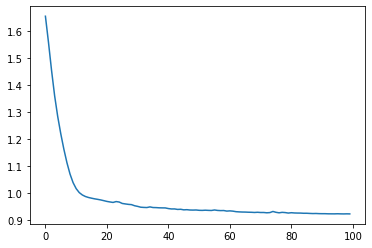

In [16]:
plt.plot(losses)
plt.show()

In [17]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [18]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.0000000e+00 1.3447704e-10 1.9076400e-14 3.1522357e-10 2.4614328e-11]
argmax를 한 후의 output은 0
accuracy는 0.9532163742690059


# 2. SGD+ ReLU, sigmoid이용 : accuracy 0.9298245614035088

binary classification(양성, 음성) 이므로 sigmoid 사용함.
BCELoss 를 사용하고자 하였으나 실패함
아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!

- 1) load_digits() <br>
- 2) load_wine()

In [19]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [20]:
X =cancer.data
Y =cancer.target

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42, stratify= cancer.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [23]:
print(x_train[0])
print(y_train[0])
#input 30개 (attributes 30개)
#y의 class는 2개 (target)
#dataset 정보 https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02])
tensor(1)


In [24]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [25]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [26]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까? 
# hidden layer/neuron 수를 바꾸기 : 2개로 결정

model = nn.Sequential(
          nn.Linear(30,64, bias=True), 
          nn.ReLU(),
          nn.Linear(64,32, bias=True),
          nn.ReLU(),
          nn.Linear(32,5, bias=True), 
          nn.Sigmoid()
          ).to(device)

In [27]:
class Model(torch.nn.Module):

 def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(30,64, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.ReLU(),
        nn.BatchNorm1d(64)
    )

  #layer 종류에 따른 활성함수의 추천 https://sanghyu.tistory.com/182 참조
  # hidden layer-mlp에 적합한 ReLU, output layer binary classification에 적합한 sigmoid 사용을 결정함.
  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(64,32, bias=True), 
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,16, bias=True), 
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 5, bias=True), 
        nn.Sigmoid()
    )

 def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [28]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [29]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\candy\AppData\Local\Temp/ipykernel_17276/2907414226.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=5, bias=True)
    (1): Sigmoid()
  )
)

In [30]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=5, bias=True)
    (1): Sigmoid()
  )
)


In [36]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기 :SGD보다 Adam이 성능 좋음
# lr 바꿔보기


optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [37]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.4003815650939941
10 1.3386380672454834
20 1.2407230138778687
30 1.1606491804122925
40 1.0913678407669067
50 1.0455197095870972
60 1.0206027030944824
70 1.005723476409912
80 0.9953458309173584
90 0.9878197312355042


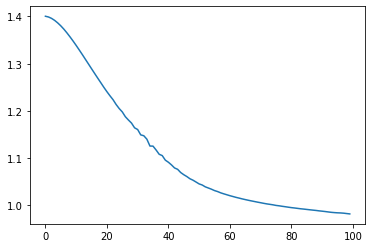

In [38]:
plt.plot(losses)
plt.show()

In [39]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [40]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.12011799 0.9910533  0.02357045 0.05024213 0.04877355]
argmax를 한 후의 output은 1
accuracy는 0.9181286549707602


# < 3주차 과제 2 : CNN 맛보기>

In [41]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [38]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



In [46]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(320 , 10) ### : 알맞는 input은?

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)
    x = self.fc(x)
    return F.log_softmax(x)

In [47]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [48]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [49]:
def test():
    model.eval() #model.eval() 의 기능은?
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [50]:
for epoch in range(1, 10):
    train(epoch)
    test()

C:\Users\candy\AppData\Local\Temp/ipykernel_25056/1801410527.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311863
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.296999
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.280773
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.275717
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.260064
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.211017
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.204179
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.118759
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.041867
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.911451
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.793231
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.463733
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.187032
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.905348
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.933150
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.763955
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.736663
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.516974
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.633448
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.596964
Train Epoch: 1 [12800/60000 (

C:\Users\candy\AppData\Local\Temp/ipykernel_25056/4274826149.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
C:\Users\candy\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1881, Accuracy: 9447/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.143864
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.314665
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.099848
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.299140
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.117232
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.209631
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.345967
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.092245
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.174963
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.200343
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.161200
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.159713
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.299889
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.075099
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.275512
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.251022
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.042217
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.190252
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.139700
Train Epoch: 2 [12